# Value fn RMSE, perfect binary tree

Experiment: (Dec 30, 2020), via `/network/tmp1/chenant/ant/sr_trace/12-30`

Today: January 12, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

Read the dfs, filter out the LSF value function agent from the `1228` runs and use the new LSF value function agent from the `1230` runs (which has the elig traces) for comparison.

In [2]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/1230_exps/exp2_binTree_LSF/small_prog.csv'

pd_df_sep = '\|\|'

In [3]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
Data_df = sf_ag_raw_df.copy(deep=True)
print(len(Data_df))
Data_df[0:5]

1277760


,"2020-12-30 17:26:27,073",num_episodes,envCls_name,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_R_fn,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2020-12-30 17:26:27,111",1000,PerfBinaryTreeEnv,SFReturnAgent,2,0.9,0.001,0.0,0.0,False,0,5,0.0,1.623098,1.623098,0.251944,0.0,0.00000,0.0,None
1,"2020-12-30 17:26:27,113",1000,PerfBinaryTreeEnv,SFReturnAgent,2,0.9,0.001,0.0,0.0,False,1,5,0.0,1.623098,1.623098,0.251944,0.0,0.00000,0.0,None
2,"2020-12-30 17:26:27,115",1000,PerfBinaryTreeEnv,SFReturnAgent,2,0.9,0.001,0.0,0.0,False,2,5,0.0,1.623098,1.623098,0.251944,0.0,0.00000,0.0,None
3,"2020-12-30 17:26:27,117",1000,PerfBinaryTreeEnv,SFReturnAgent,2,0.9,0.001,0.0,0.0,False,3,5,5.0,1.622979,1.622979,0.251944,5.0,0.16129,0.0,None
4,"2020-12-30 17:26:27,119",1000,PerfBinaryTreeEnv,SFReturnAgent,2,0.9,0.001,0.0,0.0,False,4,5,0.0,1.622979,1.622979,0.251944,0.0,0.00000,0.0,None


## Comparison with TD(0) as one-step method

(0.9, 1.0)

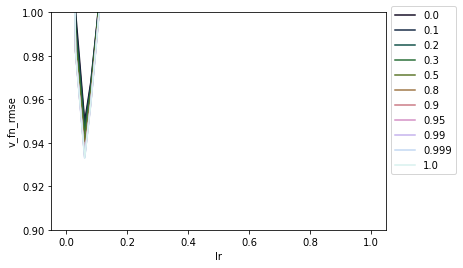

In [25]:
def script_plot_v_fn_rmse_td0_epis(df, n_episode_idx=9,
                                   xscale='linear', yscale='linear'):
    plt_x = 'lr'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 100
    
    # Filter
    df = df.copy(deep=True)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['eta_trace'] == 0.8]  # no elig trace
    
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    df = df[df['episode_idx']==n_episode_idx]
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    
    #plt.yscale([])
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    
script_plot_v_fn_rmse_td0_epis(Data_df, n_episode_idx=499)
plt.ylim([0.9, 1.0])

## Comparison: LSF with TD(lambda)

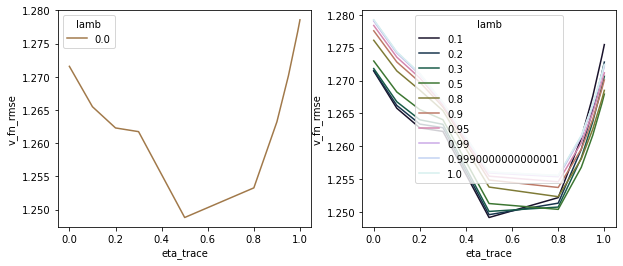

In [28]:
def script_plot_trace_best_stepsize(df, episode_idx=9, ylim=None):
    plt_x = 'eta_trace'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    plt_ci = None
    plt_n_boot = 200
    
    # ==
    # Filter
    # df = script_helper_true_param_filter(df, [False, False])  # TODO: no true rewards here right?
    df = df.copy(deep=True)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['episode_idx'] == episode_idx]
    
    # Filter for TD(lambda)
    tdlamb_df = df[df['lamb'] == 0.0] 
    # Filter for LSF
    lsf_df = df[df['lamb'] > 0.0]
    
    # ==
    # Find best lr parameters
    def best_lr_df(cur_df):
        cur_df = cur_df.groupby(['lamb', 'eta_trace', 'lr']).mean()
        cur_df_mask = cur_df.groupby(['lamb','eta_trace'])['v_fn_rmse'].transform(min) == cur_df['v_fn_rmse']
        cur_df = cur_df[cur_df_mask]
        return cur_df.reset_index()
    
    best_lr_df_dict = {}
    best_lr_df_dict['td_lambda'] = best_lr_df(tdlamb_df)
    best_lr_df_dict['lsf'] = best_lr_df(lsf_df)
    
    # ==
    # Plot
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    n_hues = len(set(best_lr_df_dict['td_lambda'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['td_lambda'])
    plt.ylim(ylim)
    
    
    plt.subplot(1,2,2)
    n_hues = len(set(best_lr_df_dict['lsf'][plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=best_lr_df_dict['lsf'])
    plt.ylim(ylim)
    
    return best_lr_df_dict
    

cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=99, ylim=None)

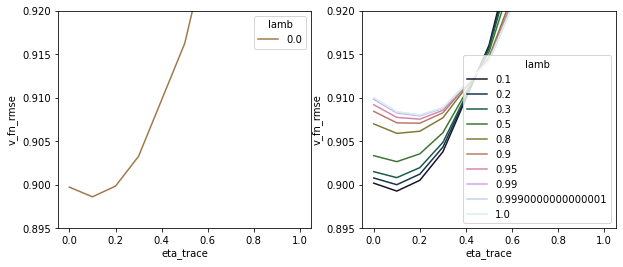

In [33]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=499, ylim=[0.895, 0.92])

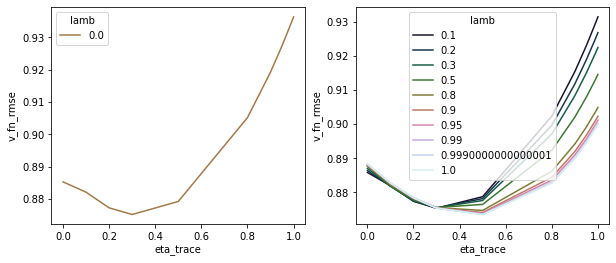

In [40]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=799)

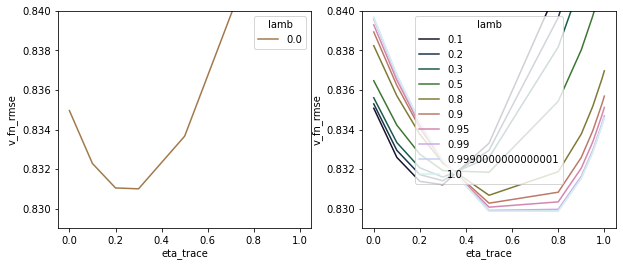

In [39]:
cur_out_dict = script_plot_trace_best_stepsize(Data_df, episode_idx=999, ylim=[0.829, 0.84])

## Comparing: LSF with difference interpolation and traces

In [5]:
print(sorted(list(set(Data_df['episode_idx']))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 74, 99, 124, 149, 174, 199, 224, 249, 274, 299, 324, 349, 374, 399, 424, 449, 474, 499, 524, 549, 574, 599, 624, 649, 674, 699, 724, 749, 774, 799, 824, 849, 874, 899, 924, 949, 974, 999]


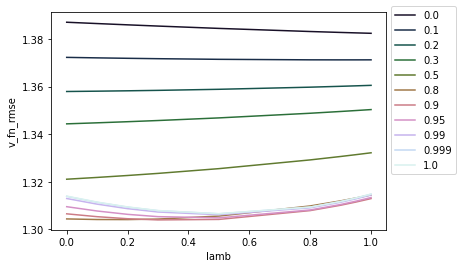

In [15]:
def script_plot_lsf_v_fn_rmse_episode(df, n_episode_idx=9, lr=0.1, 
                                      xscale='linear', yscale='linear'):
    plt_x = 'lamb'
    plt_y = 'v_fn_rmse'
    plt_hue = 'eta_trace'
    plt_ci = None
    plt_n_boot = 100
    
    # Filter
    df = df.copy(deep=True)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['lr'] == lr]
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    cur_df = df[df['episode_idx']==n_episode_idx]
    n_hues = len(set(cur_df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=plt_y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=cur_df)
    
    #plt.yscale([])
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    
script_plot_lsf_v_fn_rmse_episode(Data_df, n_episode_idx=99, lr=0.06)

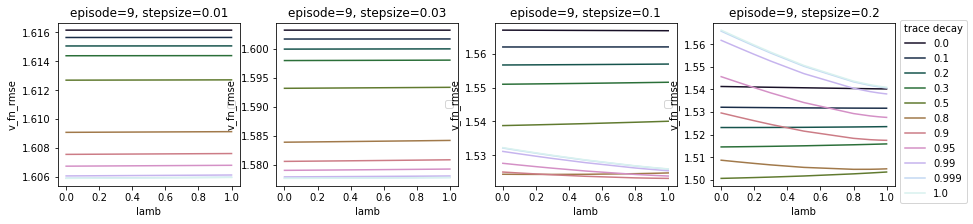

In [7]:
def script_subplot_lsf_v_rmse(df, n_episode_idx, ylim=None):
    lr_list = [0.01, 0.03, 0.1, 0.2]
    plt.figure(figsize=(15,3))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1,len(lr_list), i+1)
        script_plot_lsf_v_fn_rmse_episode(df, n_episode_idx, lr=lr)
        plt.title(f'episode={n_episode_idx}, stepsize={lr}')
        
        if ylim is None:
            #plt.ylim([0.2, 0.6])
            pass
        else:
            plt.ylim(ylim)
        
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left', title='trace decay')
        
script_subplot_lsf_v_rmse(Data_df, 9)

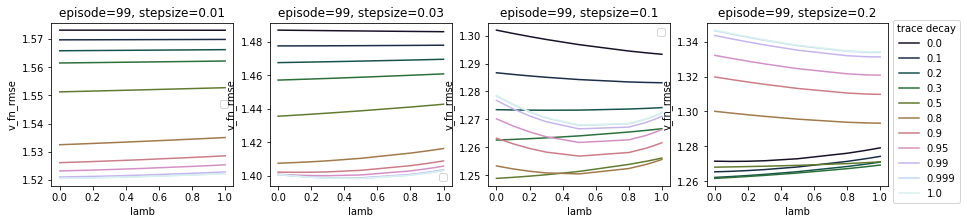

In [8]:
script_subplot_lsf_v_rmse(Data_df, 99)

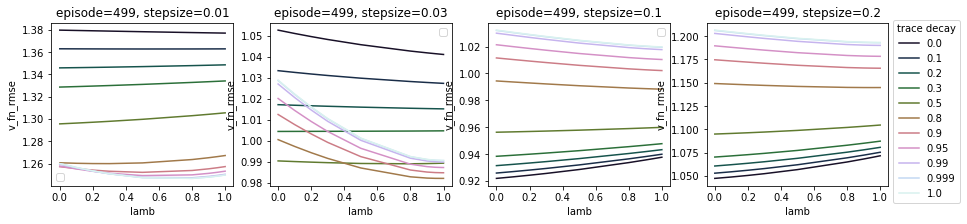

In [9]:
script_subplot_lsf_v_rmse(Data_df, 499)

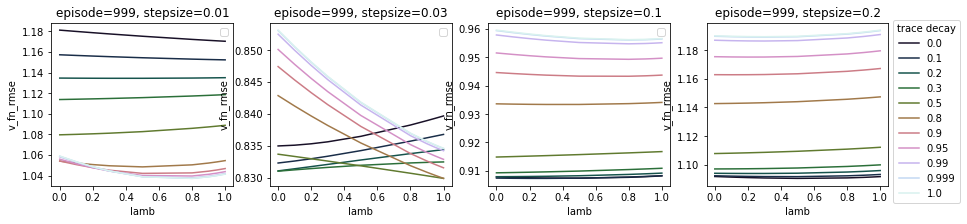

In [10]:
script_subplot_lsf_v_rmse(Data_df, 999)

## Compare: LSF value vs. MF value function errors

In [30]:
set(Data_df['lamb'])

{0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 0.95, 0.99, 0.9990000000000001, 1.0}

In [31]:
set(Data_df['eta_trace'])

{0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 0.95, 0.99, 0.9990000000000001, 1.0}

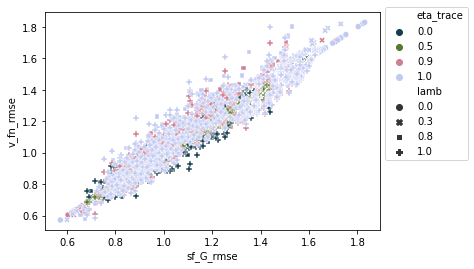

In [45]:
def script_scatter_lsf_v_fn_errors(x, y, hue, size, lr, data):
    plt_x = x
    plt_y = y
    plt_hue = hue #'eta_trace'  #'eta_trace'
    plt_size = size
    plt_ci = None
    plt_n_boot = 1
    
    # Filter
    df = data.copy(deep=True)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['lamb'].isin([0.0, 0.3, 0.8, 1.0])]
    df = df[df['eta_trace'].isin([0.0, 0.5, 0.9, 1.0])]
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    
    # Palette
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    # Filter for stepsize
    df = df
    df = df[df['lr'] == lr]
    df['lamb'] = [round(e, 3) for e in df['lamb']]
    #df['lamb'] = [str(l) for l in df['lamb'].values]
    #df = df[df['lr'] == 0.1]
    
    # sf_G_rmse, sf_matrix_rmse
    
    sns.scatterplot(x=plt_x, y=plt_y, hue=plt_hue, 
                    style=plt_size, sizes=(1, 50),
                    palette=c_palette, 
                    data=df)
    
    #sns.kdeplot(x=plt_x, y=plt_y, hue=plt_hue, fill=True, data=df)
    #plt.xlim([0.19, 0.8])
    #plt.ylim([0.19, 0.8])
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    

script_scatter_lsf_v_fn_errors(x='sf_G_rmse', y='v_fn_rmse', 
                               hue='eta_trace', size='lamb', 
                               lr=0.1,
                               data=Data_df)

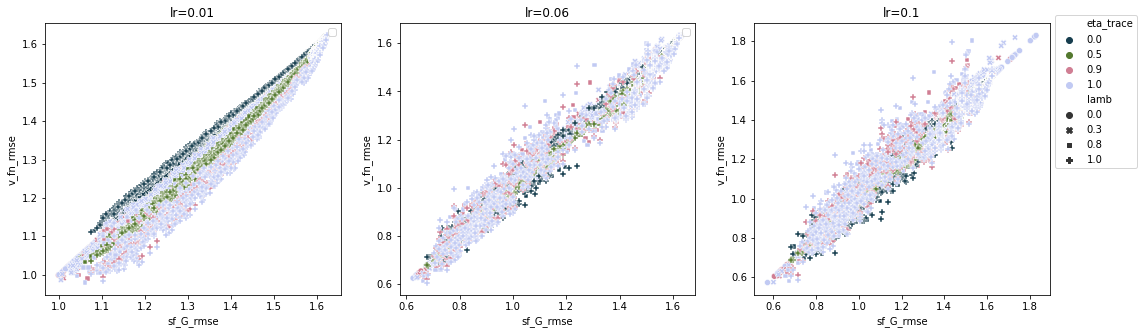

In [46]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(18, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_G_rmse', y='v_fn_rmse', 
                               hue='eta_trace', size='lamb', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()    

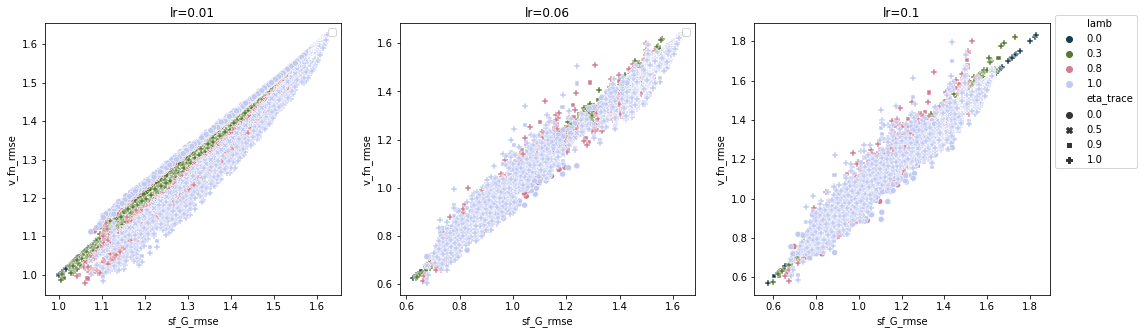

In [47]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(18, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_G_rmse', y='v_fn_rmse', 
                               hue='lamb', size='eta_trace', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()  

## Compare: SF matrix and value function
### Hue is interpolation 

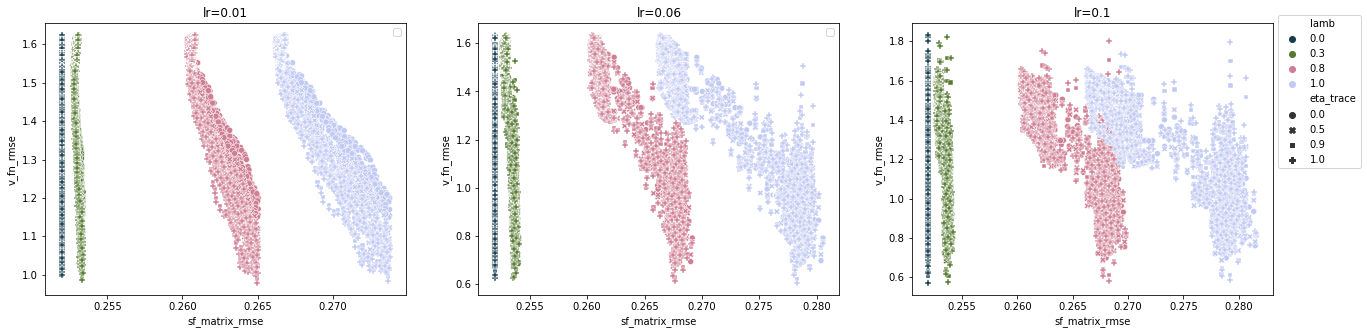

In [48]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(22, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_matrix_rmse', y='v_fn_rmse', 
                               hue='lamb', size='eta_trace', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        #plt.xlim([1e-3,5.0])
        #plt.xscale('log')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()  

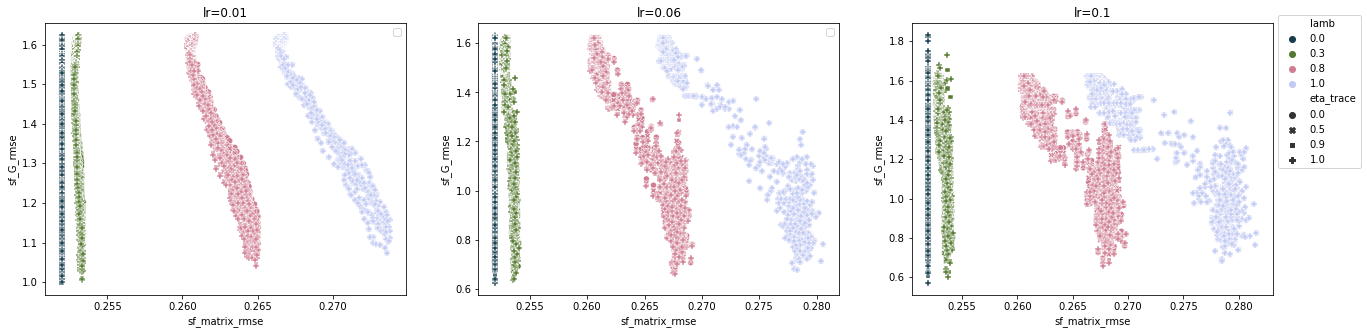

In [50]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(22, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_matrix_rmse', y='sf_G_rmse', 
                               hue='lamb', size='eta_trace', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        #plt.xlim([1e-3,5.0])
        #plt.xscale('log')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()  

### Hue is trace decay parameter

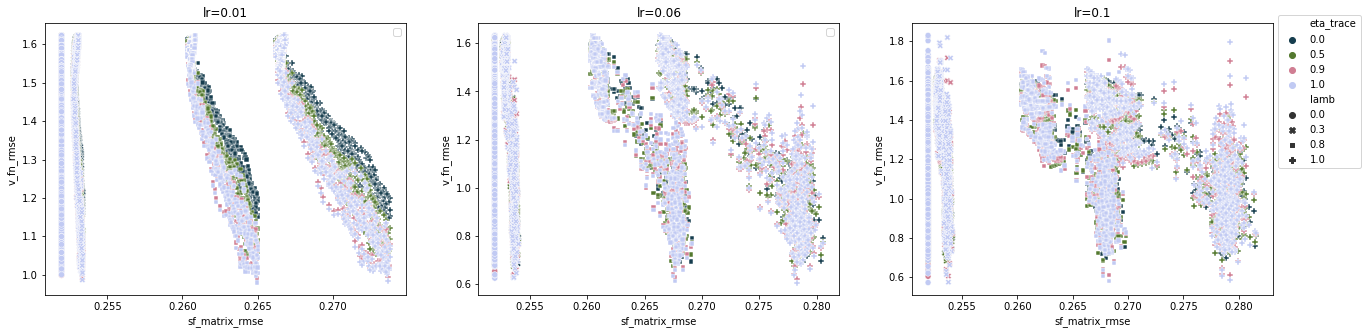

In [53]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(22, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_matrix_rmse', y='v_fn_rmse', 
                               hue='eta_trace', size='lamb', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        #plt.xlim([1e-3,5.0])
        #plt.xscale('log')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()

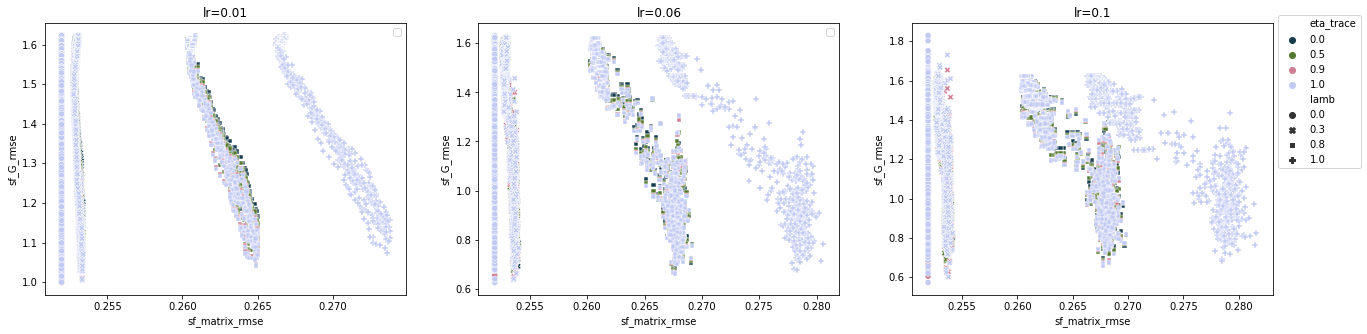

In [55]:
def script_multi_scatters():
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(22, 5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1, len(lr_list), i+1)
        script_scatter_lsf_v_fn_errors(x='sf_matrix_rmse', y='sf_G_rmse', 
                               hue='eta_trace', size='lamb', 
                               lr=lr,
                               data=Data_df)
        
        plt.title(f'lr={lr}')
        #plt.xlim([1e-3,5.0])
        #plt.xscale('log')
        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
script_multi_scatters()

## Scatter: SF error over training

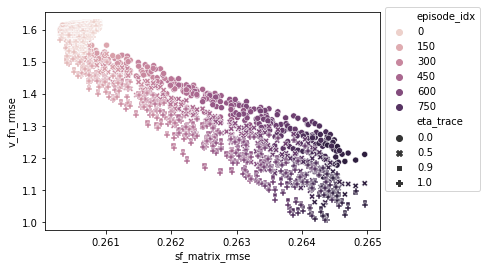

In [64]:
def script_scatter_errors_over_training(x, y, hue, size, lr, lamb, data):
    plt_x = x
    plt_y = y
    plt_hue = hue #'eta_trace'  #'eta_trace'
    plt_size = size
    plt_ci = None
    plt_n_boot = 1
    
    # Filter
    df = data.copy(deep=True)
    df = df[df['agentCls_name'] == 'SFReturnAgent']
    df = df[df['episode_idx'] <= 900]
    df = df[df['lamb'].isin([0.0, 0.1, 0.3, 0.8, 1.0])]
    df = df[df['eta_trace'].isin([0.0, 0.5, 0.9, 1.0])]
    
    # Palette
    # n_hues = len(set(df[plt_hue].values))
    # c_palette = sns.color_palette("cubehelix", n_hues) 
    
    # Filter for stepsize
    df = df
    df = df[df['lr'] == lr]
    df['lamb'] = [round(e, 3) for e in df['lamb']]
    df = df[df['lamb'] == lamb]
    
    # Plot
    sns.scatterplot(x=plt_x, y=plt_y, hue=plt_hue, 
                    style=plt_size, sizes=(1, 50),
                    data=df)
    #plt.xlim([0.19, 0.8])
    #plt.ylim([0.19, 0.8])
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    

script_scatter_errors_over_training(x='sf_matrix_rmse', y='v_fn_rmse', 
                               hue='episode_idx', size='eta_trace', 
                               lr=0.01, lamb=0.8,
                               data=Data_df)
#plt.xscale('log')

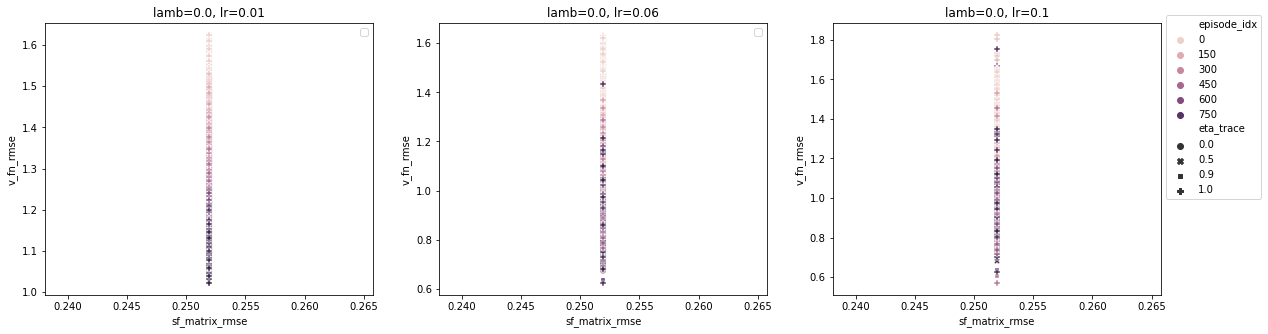

In [65]:
def script_multi_scatter_over_training(lamb):
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(20,5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1,len(lr_list), i+1)
        script_scatter_errors_over_training(x='sf_matrix_rmse', y='v_fn_rmse', 
                                   hue='episode_idx', size='eta_trace', 
                                   lr=lr, lamb=lamb,
                                   data=Data_df)
        if lamb > 0.0:
            #plt.xscale('log')
            pass
        #plt.ylim([0.19, 0.8])
        plt.title(f'lamb={lamb}, lr={lr}')

        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
        
script_multi_scatter_over_training(lamb=0.0)

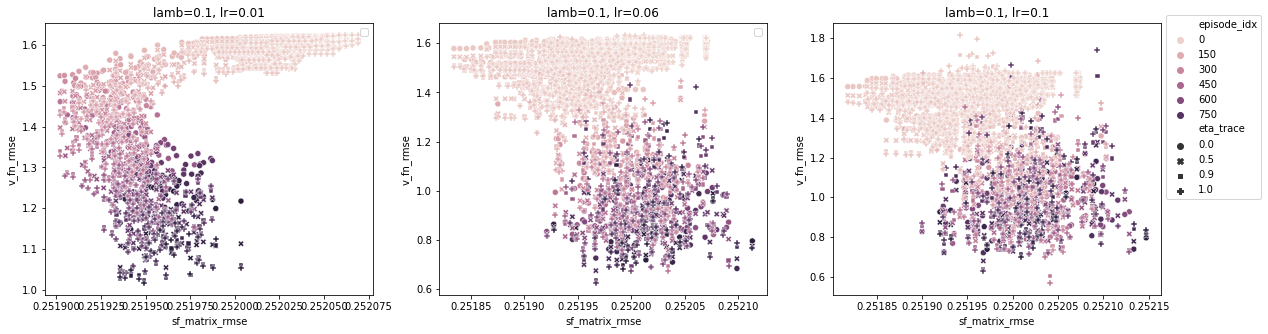

In [66]:
script_multi_scatter_over_training(lamb=0.1)

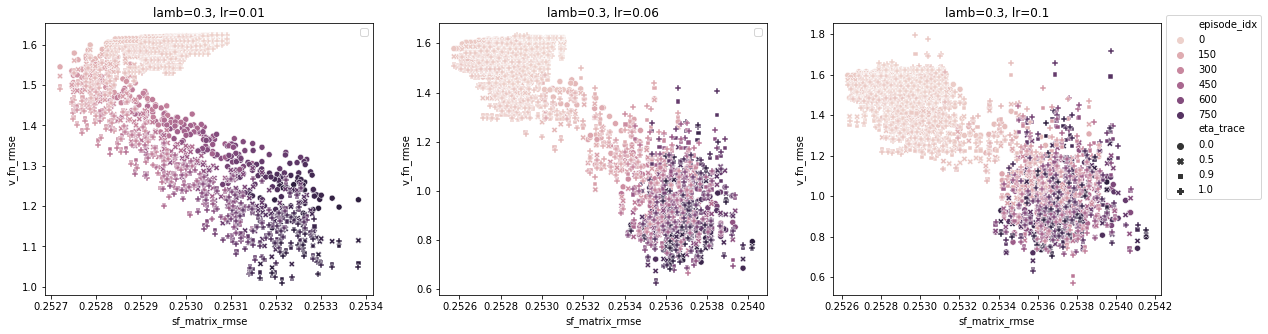

In [67]:
script_multi_scatter_over_training(lamb=0.3)

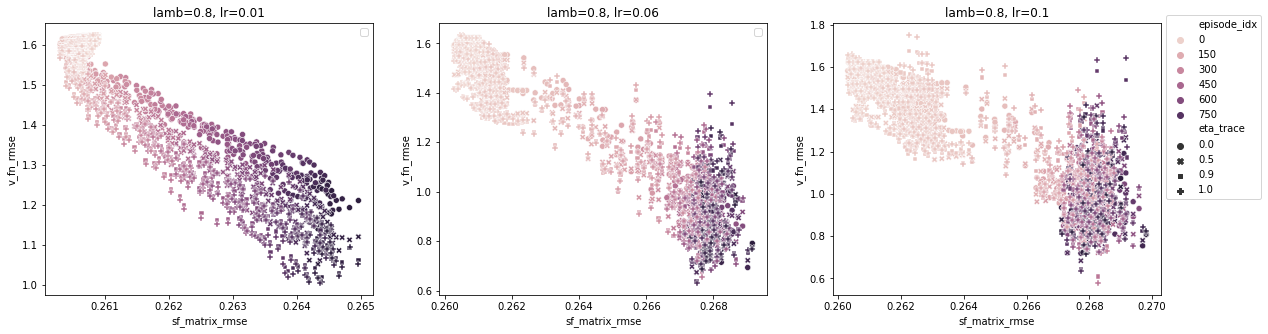

In [68]:
script_multi_scatter_over_training(lamb=0.8)

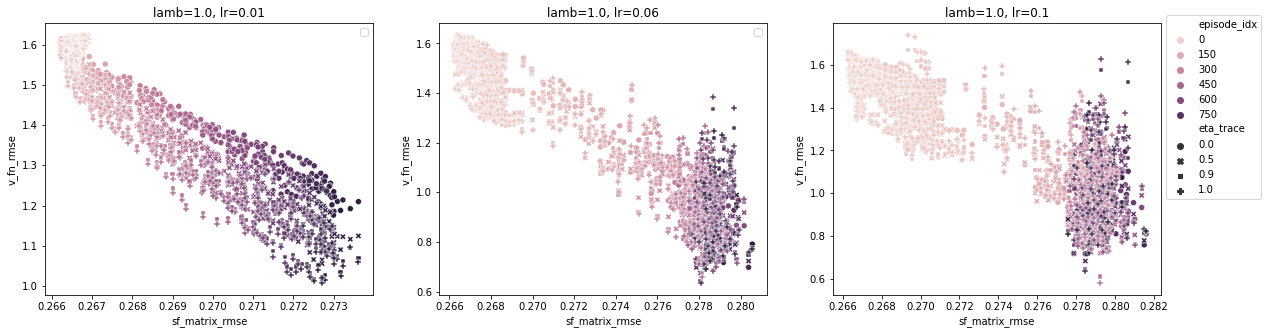

In [69]:
script_multi_scatter_over_training(lamb=1.0)

### X axis is training episode

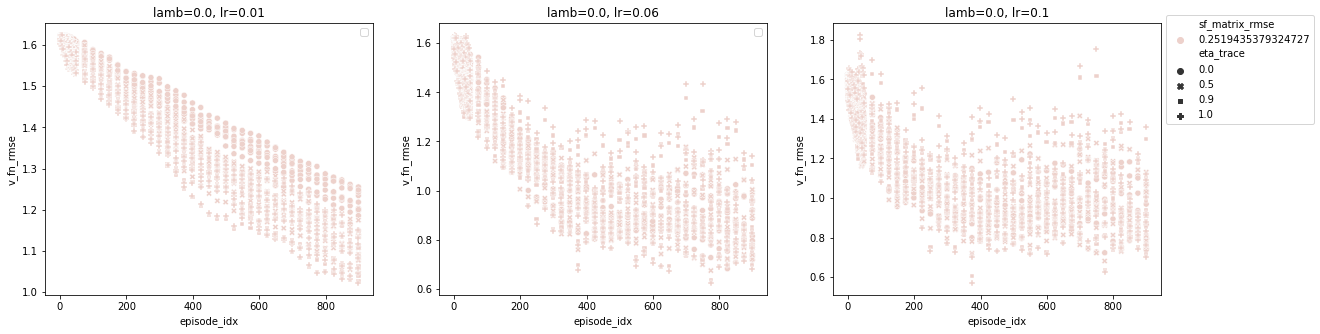

In [71]:
def script_multi_scatter_x_epis_over_training(lamb):
    lr_list = [0.01, 0.06, 0.1]
    plt.figure(figsize=(20,5))
    
    for i, lr in enumerate(lr_list):
        plt.subplot(1,len(lr_list), i+1)
        script_scatter_errors_over_training(x='episode_idx', y='v_fn_rmse', 
                                   hue='sf_matrix_rmse', size='eta_trace', 
                                   lr=lr, lamb=lamb,
                                   data=Data_df)
        if lamb > 0.0:
            #plt.xscale('log')
            pass
        #plt.ylim([0.19, 0.8])
        plt.title(f'lamb={lamb}, lr={lr}')

        # Legend
        if i < (len(lr_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
        
script_multi_scatter_x_epis_over_training(lamb=0.0)

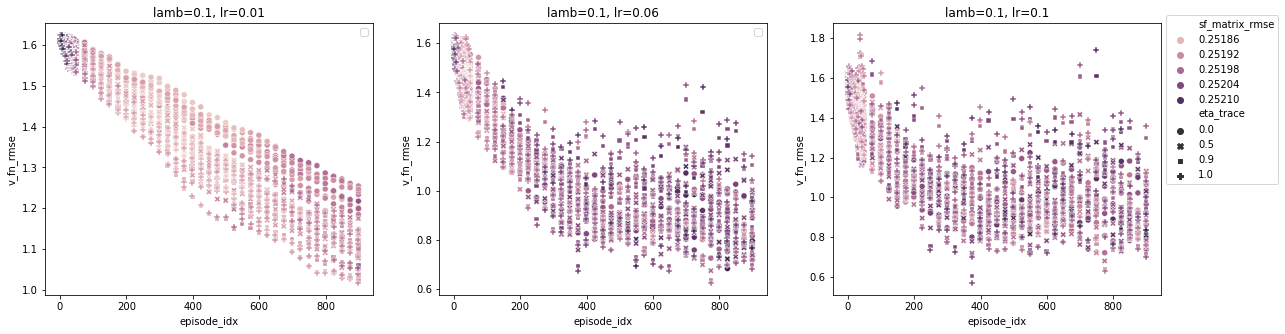

In [72]:
script_multi_scatter_x_epis_over_training(lamb=0.1)

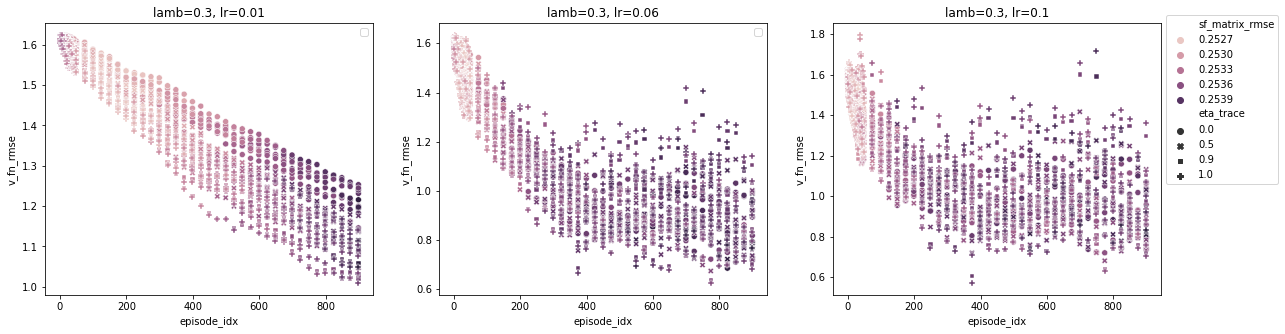

In [73]:
script_multi_scatter_x_epis_over_training(lamb=0.3)

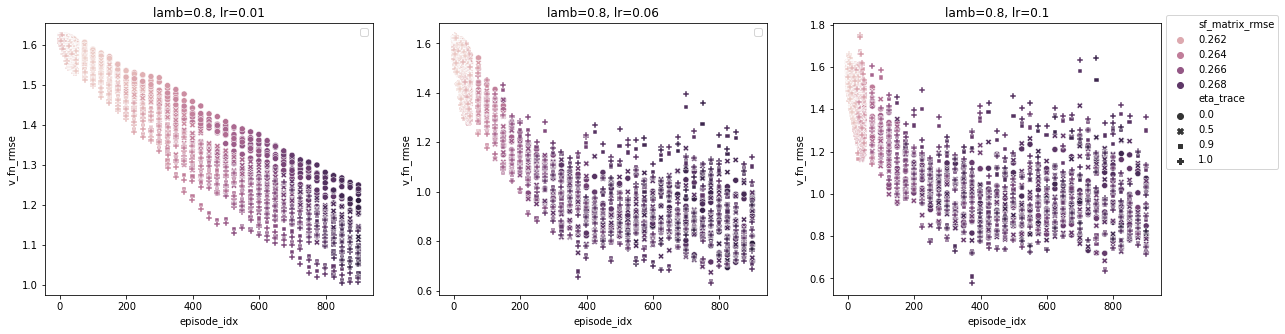

In [74]:
script_multi_scatter_x_epis_over_training(lamb=0.8)

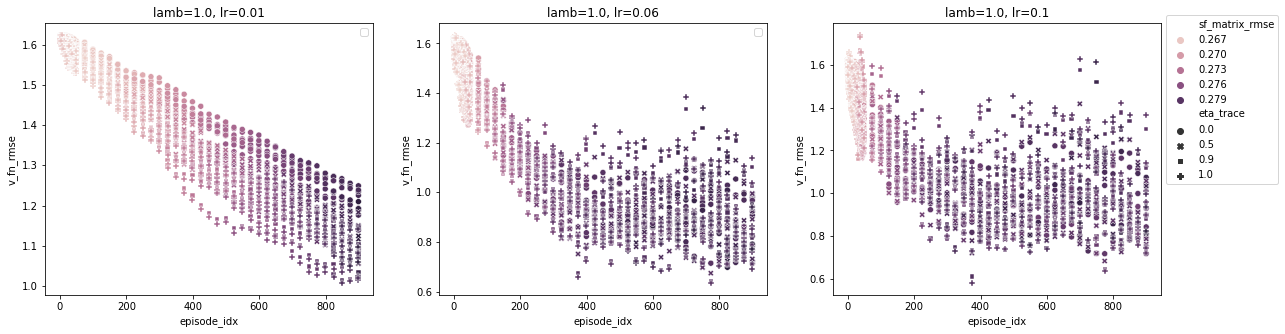

In [75]:
script_multi_scatter_x_epis_over_training(lamb=1.0)